In [2]:
from diffusers import StableDiffusionPipeline

repo_id = "runwayml/stable-diffusion-v1-5"
stable_diffusion = StableDiffusionPipeline.from_pretrained(repo_id, safety_checker=None, use_safetensors=True)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280, 8, 8])
torch.Size([2, 1280,

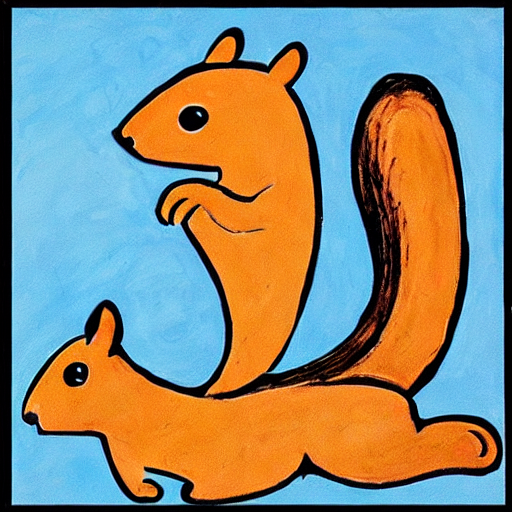

In [3]:
from diffusers import DDPMScheduler, UNet2DConditionModel
from PIL import Image
import torch

repo_id = "runwayml/stable-diffusion-v1-5"
scheduler = DDPMScheduler.from_pretrained(repo_id)
model = UNet2DConditionModel.from_pretrained(repo_id).to("cuda")
scheduler.set_timesteps(50)

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
        prev_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
        input = prev_noisy_sample

image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image